In [1]:
# Dataset building pipeline (Segmentation and Classification)
# - Segmentation: single-channel T1c, binary masks (2+3 -> 1), RAS+, 1.0 mm isotropic
# - Classification: single-channel T1c, with labels.csv; optional ROI cropping if masks available

from __future__ import annotations
from pathlib import Path
from typing import Optional, Iterable, List, Dict, Tuple, Union
import json
import os
import re
import math
import csv

import numpy as np
import nibabel as nib
import matplotlib.pyplot as plt
from dataclasses import dataclass

try:
    from scipy.ndimage import zoom as nd_zoom
except Exception as _e:
    nd_zoom = None
    print("[WARN] scipy not available; resampling functions will raise if called.")

# ---------------------------
# Core helpers (RAS, spacing, resampling, I/O)
# ---------------------------

def as_ras(img: nib.Nifti1Image) -> nib.Nifti1Image:
    return nib.as_closest_canonical(img)


def get_spacing(img: nib.Nifti1Image) -> Tuple[float, float, float]:
    z = img.header.get_zooms()
    if len(z) < 3:
        raise ValueError("Image zooms <3; not a 3D/4D image")
    return float(z[0]), float(z[1]), float(z[2])


def resample_ndarray_to_spacing(
    vol: np.ndarray,
    source_spacing: Tuple[float, float, float],
    target_spacing: Tuple[float, float, float],
    order: int,
) -> np.ndarray:
    if nd_zoom is None:
        raise RuntimeError("scipy.ndimage.zoom not available. Please install scipy.")
    zoom_factors = np.array(source_spacing, dtype=np.float64) / np.array(target_spacing, dtype=np.float64)
    # Ensure shape mapped on first 3 dims; extra dims (channels) left untouched
    if vol.ndim == 3:
        return nd_zoom(vol, zoom=zoom_factors, order=order)
    elif vol.ndim == 4:
        # Apply per channel
        channels = []
        for c in range(vol.shape[3]):
            channels.append(nd_zoom(vol[..., c], zoom=zoom_factors, order=order))
        return np.stack(channels, axis=3)
    else:
        raise ValueError(f"Unsupported ndim {vol.ndim}; expected 3 or 4")


def build_affine_for_spacing(spacing: Tuple[float, float, float]) -> np.ndarray:
    # Identity orientation with given spacing; origin at 0
    aff = np.eye(4, dtype=np.float64)
    aff[0, 0] = spacing[0]
    aff[1, 1] = spacing[1]
    aff[2, 2] = spacing[2]
    return aff


def robust_intensity_normalize(image: np.ndarray, clip_percentiles=(1, 99)) -> np.ndarray:
    valid = np.isfinite(image)
    if not np.any(valid):
        return image
    lo, hi = np.percentile(image[valid], clip_percentiles)
    if hi <= lo:
        return image
    img = np.clip(image, lo, hi)
    mean = img[valid].mean()
    std = img[valid].std() + 1e-8
    return (img - mean) / std


def save_nifti(path: Union[str, Path], data: np.ndarray, spacing: Tuple[float, float, float]) -> None:
    path = Path(path)
    path.parent.mkdir(parents=True, exist_ok=True)
    affine = build_affine_for_spacing(spacing)
    img = nib.Nifti1Image(data, affine=affine)
    nib.save(img, str(path))


# ---------------------------
# Label ops
# ---------------------------

def combine_brats_labels_to_binary(lbl: np.ndarray) -> np.ndarray:
    # Expected labels: 0 background, 1 edema, 2 non-enhancing, 3 enhancing
    # Output: 1 for (2 or 3), else 0
    out = np.zeros_like(lbl, dtype=np.uint8)
    out[(lbl == 2) | (lbl == 3)] = 1
    return out


def union_binary_masks(mask_list: List[np.ndarray]) -> np.ndarray:
    if not mask_list:
        raise ValueError("No masks provided for union.")
    out = np.zeros_like(mask_list[0], dtype=np.uint8)
    for m in mask_list:
        out = np.logical_or(out, m > 0)
    return out.astype(np.uint8)


def compute_bbox(mask: np.ndarray, margin: int = 8) -> Optional[Tuple[slice, slice, slice]]:
    idx = np.argwhere(mask > 0)
    if idx.size == 0:
        return None
    zmin, ymin, xmin = idx.min(axis=0)
    zmax, ymax, xmax = idx.max(axis=0)
    z0 = max(0, zmin - margin); z1 = min(mask.shape[0], zmax + 1 + margin)
    y0 = max(0, ymin - margin); y1 = min(mask.shape[1], ymax + 1 + margin)
    x0 = max(0, xmin - margin); x1 = min(mask.shape[2], xmax + 1 + margin)
    return (slice(z0, z1), slice(y0, y1), slice(x0, x1))


# ---------------------------
# nnU-Net dataset parsing (for data_brainMRI_Segmentation)
# ---------------------------

def parse_nnunet_dataset(root_path: str) -> Dict[str, object]:
    root = Path(root_path)
    ds_json = root / "dataset.json"
    if not ds_json.exists():
        raise FileNotFoundError(f"dataset.json not found at: {ds_json}")
    with ds_json.open("r") as f:
        meta = json.load(f)
    modalities = [v for _, v in sorted(((int(k), v) for k, v in meta.get("modality", {}).items()), key=lambda x: x[0])]
    training_entries = []
    for item in meta.get("training", []):
        image_rel = item["image"]
        label_rel = item["label"]
        training_entries.append({
            "case_id": Path(image_rel).stem,
            "image_path": str((root / image_rel).resolve()),
            "label_path": str((root / label_rel).resolve()),
        })
    return {"modalities": modalities, "training": training_entries, "meta": meta}


def get_t1c_channel_index(modalities: List[str]) -> int:
    # Prefer t1gd, fallback to t1c
    low = [m.lower() for m in modalities]
    if "t1gd" in low:
        return low.index("t1gd")
    if "t1c" in low:
        return low.index("t1c")
    raise ValueError(f"Neither t1gd nor t1c found in modalities: {modalities}")



In [2]:
# ---------------------------
# Shape harmonization helpers (pad/crop to fixed size)
# ---------------------------

def pad_or_crop_to_shape(vol: np.ndarray, target_shape: Tuple[int, int, int], pad_value: float | int = 0) -> np.ndarray:
    """Center pad or center crop a 3D volume to target_shape (Z, Y, X).
    If vol is not 3D, raises. Pads with pad_value, crops centered.
    """
    if vol.ndim != 3:
        raise ValueError(f"pad_or_crop_to_shape expects 3D array, got {vol.ndim}D")
    tz, ty, tx = target_shape
    z, y, x = vol.shape

    # First crop if larger
    cz0 = max(0, (z - tz) // 2); cz1 = cz0 + min(z, tz)
    cy0 = max(0, (y - ty) // 2); cy1 = cy0 + min(y, ty)
    cx0 = max(0, (x - tx) // 2); cx1 = cx0 + min(x, tx)
    cropped = vol[cz0:cz1, cy0:cy1, cx0:cx1]

    # Then pad if smaller
    zc, yc, xc = cropped.shape
    pz_before = max(0, (tz - zc) // 2); pz_after = max(0, tz - zc - pz_before)
    py_before = max(0, (ty - yc) // 2); py_after = max(0, ty - yc - py_before)
    px_before = max(0, (tx - xc) // 2); px_after = max(0, tx - xc - px_before)

    if any(v > 0 for v in (pz_before, pz_after, py_before, py_after, px_before, px_after)):
        padded = np.pad(
            cropped,
            pad_width=((pz_before, pz_after), (py_before, py_after), (px_before, px_after)),
            mode="constant",
            constant_values=pad_value,
        )
    else:
        padded = cropped

    return padded


In [3]:
# ---------------------------
# Source loaders (BCBM-like folders)
# ---------------------------

@dataclass
class BCBMCase:
    case_id: str
    image_path: Path
    mask_paths: List[Path]


def discover_bcbm_cases(root_path: str) -> List[BCBMCase]:
    root = Path(root_path)
    cases: List[BCBMCase] = []
    for d in sorted([p for p in root.iterdir() if p.is_dir()]):
        img = None
        masks: List[Path] = []
        for f in d.iterdir():
            if not f.is_file():
                continue
            name = f.name
            if name.endswith("_image_ss_n4.nii.gz"):
                img = f
            elif "_mask_" in name and name.lower().endswith(".nii.gz"):
                masks.append(f)
        if img is not None and masks:
            cases.append(BCBMCase(case_id=d.name, image_path=img, mask_paths=masks))
    return cases



In [4]:
# ---------------------------
# Segmentation dataset builder
# ---------------------------

@dataclass
class SegBuildConfig:
    # Inputs
    nnunet_root: str                   # e.g., data_brainMRI_Segmentation
    bcbm_root: str                     # e.g., PKG-BCBM-RadioGenomics_Images_Masks_Dec2024/BCBM_KSC_curated_data
    # Outputs
    out_root: str                      # destination root containing imagesTr/, labelsTr/, dataset.json
    # Processing
    target_spacing: Tuple[float, float, float] = (1.0, 1.0, 1.0)
    do_crop_to_mask: bool = False
    crop_margin: int = 8
    target_shape: Tuple[int, int, int] = (192, 192, 160)


def build_segmentation_dataset(cfg: SegBuildConfig) -> Dict[str, object]:
    out_images = Path(cfg.out_root) / "imagesTr"
    out_labels = Path(cfg.out_root) / "labelsTr"
    out_images.mkdir(parents=True, exist_ok=True)
    out_labels.mkdir(parents=True, exist_ok=True)

    case_index: List[Dict[str, str]] = []

    # 1) nnU-Net source (glioma)
    ds = parse_nnunet_dataset(cfg.nnunet_root)
    t1c_idx = get_t1c_channel_index(ds["modalities"])  # should be 2

    for entry in ds["training"]:
        case_id = entry["case_id"]
        img_4d = nib.load(entry["image_path"])  # on-disk 4D
        lbl_3d = nib.load(entry["label_path"])  # on-disk 3D

        img_4d = as_ras(img_4d)
        lbl_3d = as_ras(lbl_3d)

        img_4d_arr = img_4d.get_fdata(dtype=np.float32)
        img_t1c = img_4d_arr[..., t1c_idx]
        lbl_arr = lbl_3d.get_fdata(dtype=np.float32)
        lbl_arr = np.rint(lbl_arr).astype(np.int16)
        bin_lbl = combine_brats_labels_to_binary(lbl_arr)

        # Resample to target spacing
        sp_img = get_spacing(img_4d)
        sp_lbl = get_spacing(lbl_3d)
        img_rs = resample_ndarray_to_spacing(img_t1c, sp_img, cfg.target_spacing, order=1)
        lbl_rs = resample_ndarray_to_spacing(bin_lbl.astype(np.uint8), sp_lbl, cfg.target_spacing, order=0)

        # Normalize
        img_rs = robust_intensity_normalize(img_rs)

        # Optional crop (disabled by default)
        if cfg.do_crop_to_mask:
            bb = compute_bbox(lbl_rs, margin=cfg.crop_margin)
            if bb is not None:
                img_rs = img_rs[bb]
                lbl_rs = lbl_rs[bb]

        # Enforce fixed target shape (center pad/crop)
        img_rs = pad_or_crop_to_shape(img_rs, cfg.target_shape, pad_value=0.0)
        lbl_rs = pad_or_crop_to_shape(lbl_rs, cfg.target_shape, pad_value=0)

        # Save
        img_out = out_images / f"{case_id}.nii.gz"
        lbl_out = out_labels / f"{case_id}.nii.gz"
        save_nifti(img_out, img_rs.astype(np.float32), cfg.target_spacing)
        save_nifti(lbl_out, lbl_rs.astype(np.uint8), cfg.target_spacing)
        case_index.append({"case_id": case_id, "image": str(img_out), "label": str(lbl_out), "source": "nnunet"})

    # 2) BCBM source (mets)
    for case in discover_bcbm_cases(cfg.bcbm_root):
        case_id = case.case_id
        img = as_ras(nib.load(str(case.image_path)))
        img_arr = img.get_fdata(dtype=np.float32)
        # union all masks
        masks = []
        for m in case.mask_paths:
            m_arr = as_ras(nib.load(str(m))).get_fdata(dtype=np.float32)
            masks.append((m_arr > 0).astype(np.uint8))
        if not masks:
            continue
        bin_lbl = union_binary_masks(masks)

        # Resample
        sp_img = get_spacing(img)
        img_rs = resample_ndarray_to_spacing(img_arr, sp_img, cfg.target_spacing, order=1)
        lbl_rs = resample_ndarray_to_spacing(bin_lbl, sp_img, cfg.target_spacing, order=0)

        # Normalize
        img_rs = robust_intensity_normalize(img_rs)

        # Optional crop (disabled by default)
        if cfg.do_crop_to_mask:
            bb = compute_bbox(lbl_rs, margin=cfg.crop_margin)
            if bb is not None:
                img_rs = img_rs[bb]
                lbl_rs = lbl_rs[bb]

        # Enforce fixed target shape (center pad/crop)
        img_rs = pad_or_crop_to_shape(img_rs, cfg.target_shape, pad_value=0.0)
        lbl_rs = pad_or_crop_to_shape(lbl_rs, cfg.target_shape, pad_value=0)

        # Save
        img_out = out_images / f"{case_id}.nii.gz"
        lbl_out = out_labels / f"{case_id}.nii.gz"
        save_nifti(img_out, img_rs.astype(np.float32), cfg.target_spacing)
        save_nifti(lbl_out, lbl_rs.astype(np.uint8), cfg.target_spacing)
        case_index.append({"case_id": case_id, "image": str(img_out), "label": str(lbl_out), "source": "bcbm"})

    # Write dataset.json
    dsj = {
        "name": "Segmentation-T1c-Binary",
        "tensorImageSize": "3D",
        "modality": {"0": "t1gd"},
        "labels": {"0": "background", "1": "tumor"},
        "numTraining": len(case_index),
        "training": [{"image": os.path.relpath(ci["image"], cfg.out_root), "label": os.path.relpath(ci["label"], cfg.out_root)} for ci in case_index],
        "numTest": 0,
        "test": []
    }
    with open(Path(cfg.out_root) / "dataset.json", "w") as f:
        json.dump(dsj, f, indent=2)

    print(f"[DONE] Segmentation dataset written: {cfg.out_root} | cases: {len(case_index)}")
    return {"cases": case_index, "out_root": cfg.out_root}



In [5]:
# ---------------------------
# Classification dataset builder
# ---------------------------

@dataclass
class ClsBuildConfig:
    # Inputs (list of (root, class_label, pattern) configs)
    # Each source root should contain per-case folders or files from which we can locate a T1c-equivalent
    sources: List[Dict[str, str]]  # dict keys: root, label ("0" or "1"), pattern (regex or glob hint)
    # Optional masks roots to crop ROI (if available). If not, ROI can be predicted later.
    roi_masks: Optional[List[Dict[str, str]]] = None  # list of dicts: root, pattern
    # Output
    out_root: str = ""
    # Processing
    target_spacing: Tuple[float, float, float] = (1.0, 1.0, 1.0)
    do_roi_crop: bool = False
    roi_margin: int = 8
    target_shape: Tuple[int, int, int] = (192, 192, 160)


def find_t1c_in_source(case_path: Path) -> Optional[Path]:
    # Heuristics: look for common T1c naming
    candidates = []
    for f in case_path.rglob("*.nii.gz"):
        n = f.name.lower()
        if ("t1gd" in n) or ("t1c" in n) or n.endswith("_image_ss_n4.nii.gz") or ("t1post" in n) or ("t1postcontrast" in n):
            candidates.append(f)
    # Prefer more specific
    order = ["t1gd", "t1c", "t1post", "t1postcontrast", "_image_ss_n4.nii.gz"]
    for key in order:
        for f in candidates:
            if key in f.name.lower() or f.name.endswith("_image_ss_n4.nii.gz"):
                return f
    return candidates[0] if candidates else None


def roi_crop(img: np.ndarray, mask: np.ndarray, margin: int = 8) -> Tuple[np.ndarray, Optional[Tuple[slice, slice, slice]]]:
    bb = compute_bbox(mask, margin=margin)
    if bb is None:
        return img, None
    return img[bb], bb


def build_classification_dataset(cfg: ClsBuildConfig) -> Dict[str, object]:
    out_images = Path(cfg.out_root) / "imagesTr"
    out_images.mkdir(parents=True, exist_ok=True)
    labels_csv = Path(cfg.out_root) / "labels.csv"

    rows: List[Tuple[str, int, str]] = []  # (case_id, label, image_path)

    # Index optional mask lookups
    mask_index: Dict[str, Path] = {}
    if cfg.roi_masks:
        for m in cfg.roi_masks:
            root = Path(m["root"]).resolve()
            pat = re.compile(m.get("pattern", r".*"), re.IGNORECASE)
            for f in root.rglob("*.nii.gz"):
                if pat.search(f.name):
                    cid = re.sub(r"\.nii\.gz$", "", f.name)
                    mask_index[cid] = f

    for src in cfg.sources:
        root = Path(src["root"]).resolve()
        label = int(src["label"])  # 0 glioma, 1 mets
        pat_str = src.get("pattern", r".*")
        pat = re.compile(pat_str, re.IGNORECASE)

        # Discover cases
        case_dirs = [p for p in root.iterdir() if p.is_dir() and pat.search(p.name)]
        files_flat = [p for p in root.iterdir() if p.is_file() and p.suffix.endswith(".gz") and pat.search(p.name)]
        if files_flat:
            case_dirs += [f.parent for f in files_flat]

        for cdir in sorted(set(case_dirs)):
            t1 = find_t1c_in_source(cdir)
            if t1 is None:
                # try one level deeper
                for sub in cdir.iterdir():
                    if sub.is_dir():
                        t1 = find_t1c_in_source(sub)
                        if t1 is not None:
                            break
            if t1 is None:
                print(f"[SKIP] No T1c found in {cdir}")
                continue

            img = as_ras(nib.load(str(t1)))
            arr = img.get_fdata(dtype=np.float32)
            sp = get_spacing(img)

            # ROI crop if we have a matching mask
            if cfg.do_roi_crop:
                # Try to find a mask by id prefix
                cid = cdir.name
                cand_mask = None
                # direct match by folder name
                for k, mpath in mask_index.items():
                    if cid in k:
                        cand_mask = mpath
                        break
                if cand_mask is not None:
                    m = as_ras(nib.load(str(cand_mask))).get_fdata(dtype=np.float32)
                    m = (m > 0).astype(np.uint8)
                    arr, _ = roi_crop(arr, m, margin=cfg.roi_margin)

            # Resample & normalize
            arr = resample_ndarray_to_spacing(arr, sp, cfg.target_spacing, order=1)
            arr = robust_intensity_normalize(arr)

            # Enforce fixed target shape (center pad/crop)
            arr = pad_or_crop_to_shape(arr, cfg.target_shape, pad_value=0.0)

            out_path = out_images / f"{cdir.name}.nii.gz"
            save_nifti(out_path, arr.astype(np.float32), cfg.target_spacing)
            rows.append((cdir.name, label, str(out_path)))

    # Write labels.csv
    with labels_csv.open("w", newline="") as f:
        w = csv.writer(f)
        w.writerow(["case_id", "label", "image_path"])  # label: 0 glioma, 1 mets
        for r in rows:
            w.writerow(list(r))

    print(f"[DONE] Classification dataset written: {cfg.out_root} | cases: {len(rows)}")
    return {"rows": rows, "out_root": cfg.out_root}



In [6]:
# ---------------------------
# Validation and quick viewers
# ---------------------------

def validate_nifti_dir(img_dir: str, label_dir: Optional[str] = None, head: int = 5) -> None:
    img_dir = Path(img_dir)
    lbl_dir = Path(label_dir) if label_dir else None
    imgs = sorted([p for p in img_dir.glob("*.nii.gz")])
    print(f"Images: {len(imgs)} | Dir: {img_dir}")
    for p in imgs[:head]:
        img = nib.load(str(p))
        sp = get_spacing(img)
        print(f" - {p.name}: shape={img.shape}, spacing={sp}")
        if lbl_dir:
            lblp = lbl_dir / p.name
            if lblp.exists():
                lbl = nib.load(str(lblp))
                print(f"   label: shape={lbl.shape}, spacing={get_spacing(lbl)}")
            else:
                print("   label: MISSING")


def show_overlay(img_path: str, lbl_path: Optional[str] = None, axis: int = 2, idx: Optional[int] = None):
    img = nib.load(img_path)
    img = as_ras(img)
    vol = img.get_fdata(dtype=np.float32)
    if vol.ndim == 4:
        vol = vol[..., 0]
    if idx is None:
        idx = vol.shape[axis] // 2
    sl = vol.take(indices=idx, axis=axis)
    plt.figure(figsize=(5, 5))
    plt.imshow((sl - sl.min()) / (sl.max() - sl.min() + 1e-8), cmap="gray")
    if lbl_path is not None and Path(lbl_path).exists():
        lbl = nib.load(lbl_path)
        lbl = as_ras(lbl)
        m = lbl.get_fdata(dtype=np.float32).astype(np.uint8).take(indices=min(idx, lbl.shape[axis]-1), axis=axis)
        plt.imshow(np.ma.masked_where(m == 0, m), cmap="autumn", alpha=0.4, interpolation="nearest")
    plt.axis("off"); plt.show()



In [ ]:
# ---------------------------
# Usage examples (edit paths and run)
# ---------------------------

# 1) Build segmentation dataset
# seg_cfg = SegBuildConfig(
#     nnunet_root="/Users/chufal/projects/DHAI-Brain-Segmentation/data_brainMRI_Segmentation",
#     bcbm_root="/Users/chufal/projects/Datasets/PKG-BCBM-RadioGenomics_Images_Masks_Dec2024/BCBM_KSC_curated_data",
#     out_root="/Users/chufal/projects/DHAI-Brain-Segmentation/derived/segmentation_t1c_binary",
#     target_spacing=(1.0, 1.0, 1.0),
#     do_crop_to_mask=True,
#     crop_margin=8,
# )
# seg_info = build_segmentation_dataset(seg_cfg)
# validate_nifti_dir(f"{seg_cfg.out_root}/imagesTr", f"{seg_cfg.out_root}/labelsTr", head=5)
# # Quick visual
# # show_overlay(seg_info["cases"][0]["image"], seg_info["cases"][0]["label"]) 

# 2) Build classification dataset
# cls_cfg = ClsBuildConfig(
#     sources=[
#         {"root": "/Users/chufal/projects/Datasets/PKG-Pretreat-MetsToBrain-Masks/Pretreat-MetsToBrain-Masks", "label": "1"},  # mets
#         {"root": "/Users/chufal/projects/Datasets/PKG-UCSD-PTGBM-v1/UCSD-PTGBM", "label": "0"},                            # glioma (if T1c present)
#         {"root": "/Users/chufal/projects/Datasets/PKG-BraTS-Africa/BraTS-Africa/95_Glioma", "label": "0"},                 # glioma
#     ],
#     roi_masks=None,  # optionally add mask directories to crop ROI
#     out_root="/Users/chufal/projects/DHAI-Brain-Segmentation/derived/classification_t1c",
#     target_spacing=(1.0, 1.0, 1.0),
#     do_roi_crop=False,
#     roi_margin=8,
# )
# cls_info = build_classification_dataset(cls_cfg)
# print(f"Wrote labels.csv at {cls_cfg.out_root}")
# validate_nifti_dir(f"{cls_cfg.out_root}/imagesTr", head=5)



In [ ]:
seg_cfg = SegBuildConfig(
    nnunet_root="/Users/chufal/projects/DHAI-Brain-Segmentation/data_brainMRI_Segmentation",
    bcbm_root="/Users/chufal/projects/Datasets/PKG-BCBM-RadioGenomics_Images_Masks_Dec2024/BCBM_KSC_curated_data",
    out_root="/Users/chufal/projects/DHAI-Brain-Segmentation/derived/segmentation_t1c_binary",
    target_spacing=(1.0, 1.0, 1.0),
    do_crop_to_mask=False,
    target_shape=(192, 192, 155),
)
seg_info = build_segmentation_dataset(seg_cfg)


In [7]:
validate_nifti_dir(f"{seg_cfg.out_root}/imagesTr", f"{seg_cfg.out_root}/labelsTr", head=5)

NameError: name 'seg_cfg' is not defined

In [ ]:
# Quick visual
show_overlay(seg_info["cases"][350]["image"], seg_info["cases"][350]["label"]) 

In [1]:
from dataset_review import launch_segmentation_dataset_viewer, summarize_shapes_and_counts, quick_view_case, launch_classification_dataset_viewer

In [9]:
root = "/Users/chufal/projects/DHAI-Brain-Segmentation/derived/segmentation_t1c_binary"
summarize_shapes_and_counts(root)         # quick summary


Cases: 748
- BRATS_457.nii: image (192, 192, 155), label (192, 192, 155) | labels {0: 5710655, 1: 3265}
- BRATS_306.nii: image (192, 192, 155), label (192, 192, 155) | labels {0: 5705640, 1: 8280}
- BRATS_206.nii: image (192, 192, 155), label (192, 192, 155) | labels {0: 5663079, 1: 50841}
- BRATS_449.nii: image (192, 192, 155), label (192, 192, 155) | labels {0: 5641814, 1: 72106}
- BRATS_318.nii: image (192, 192, 155), label (192, 192, 155) | labels {0: 5685448, 1: 28472}
- BRATS_218.nii: image (192, 192, 155), label (192, 192, 155) | labels {0: 5608636, 1: 105284}
- BRATS_434.nii: image (192, 192, 155), label (192, 192, 155) | labels {0: 5686427, 1: 27493}
- BRATS_365.nii: image (192, 192, 155), label (192, 192, 155) | labels {0: 5694903, 1: 19017}
- BRATS_265.nii: image (192, 192, 155), label (192, 192, 155) | labels {0: 5602816, 1: 111104}
- BRATS_214.nii: image (192, 192, 155), label (192, 192, 155) | labels {0: 5697684, 1: 16236}


In [ ]:
launch_segmentation_dataset_viewer(root)  # interactive review

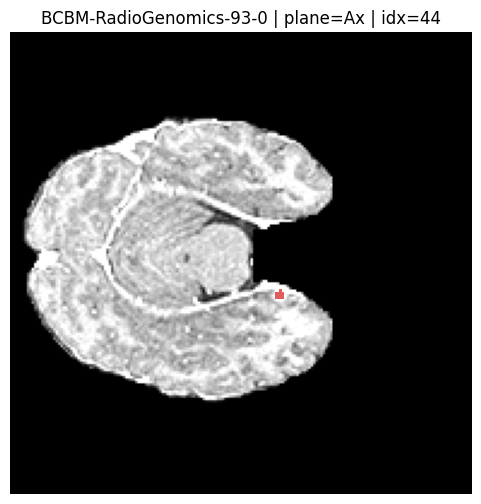

In [12]:
# Optional one-off view
quick_view_case(root, case_id="BCBM-RadioGenomics-93-0", plane=2, index=44, alpha=0.75, contour_only=False)

In [13]:
cls_cfg = ClsBuildConfig(
    sources=[
        {"root": "/Users/chufal/projects/Datasets/PKG-Pretreat-MetsToBrain-Masks/Pretreat-MetsToBrain-Masks", "label": "1"},
        {"root": "/Users/chufal/projects/Datasets/PKG-UCSD-PTGBM-v1/UCSD-PTGBM", "label": "0"},
        {"root": "/Users/chufal/projects/Datasets/PKG-BraTS-Africa/BraTS-Africa/95_Glioma", "label": "0"},
    ],
    out_root="/Users/chufal/projects/DHAI-Brain-Segmentation/derived/classification_t1c",
    target_spacing=(1.0, 1.0, 1.0),
    target_shape=(192, 192, 160),
    do_roi_crop=False,
)
cls_info = build_classification_dataset(cls_cfg)

[DONE] Classification dataset written: /Users/chufal/projects/DHAI-Brain-Segmentation/derived/classification_t1c | cases: 479


In [14]:
validate_nifti_dir(f"{cls_cfg.out_root}/imagesTr", head=5)

Images: 479 | Dir: /Users/chufal/projects/DHAI-Brain-Segmentation/derived/classification_t1c/imagesTr
 - BraTS-MET-00086-000.nii.gz: shape=(192, 192, 160), spacing=(1.0, 1.0, 1.0)
 - BraTS-MET-00089-000.nii.gz: shape=(192, 192, 160), spacing=(1.0, 1.0, 1.0)
 - BraTS-MET-00090-000.nii.gz: shape=(192, 192, 160), spacing=(1.0, 1.0, 1.0)
 - BraTS-MET-00096-000.nii.gz: shape=(192, 192, 160), spacing=(1.0, 1.0, 1.0)
 - BraTS-MET-00097-000.nii.gz: shape=(192, 192, 160), spacing=(1.0, 1.0, 1.0)


In [ ]:
root_cls = "/Users/chufal/projects/DHAI-Brain-Segmentation/derived/classification_t1c"
launch_classification_dataset_viewer(root_cls)